### Train Tiny GPT

In this notebook a small GPT-like decoder only LLM is trained

In [416]:
import os
import random
import time
from IPython.display import clear_output

import numpy as np

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

from model import TinyGPT, Config
from generate import generate
from data.dataset import CharDataset 
from data.tokenizer import Tokenizer

In [ ]:
# Automatically reload modules outside of this notebook on change
%load_ext autoreload
%autoreload 2

In [411]:
train_ids_path = os.path.join('./data/train_ids.pt')
val_ids_path = os.path.join('./data/val_ids.pt')
unique_token_ids_path = os.path.join('./data/token_id_vocab.pt')

train_ids = torch.load(train_ids_path)
val_ids = torch.load(val_ids_path)
unique_token_ids = torch.load(unique_token_ids_path)

In [412]:
tokenizer = Tokenizer(unique_token_ids)

In [437]:
device = torch.device("mps")

config = Config()

config.n_embd = tokenizer.n_vocab
config.padding_idx = tokenizer.padding_idx

train_dataset = CharDataset(config, train_ids)
val_dataset = CharDataset(config, val_ids)

model = TinyGPT(config)

In [415]:
# Double check data-set
tokenizer.decode(train_dataset.__getitem__(1)[0])

'Once upon a time, there was a little girl named Lily. She had a teddy bear that she loved so much. One day, she lost it while playing in the park. She looked everywhere, but she couldn\'t find it. She felt sad and scared without her teddy bear.  Lily\'s mommy saw her crying and asked what was wrong. Lily told her that she lost her teddy bear. Mommy hugged her and said, "Don\'t worry, we\'ll search for it together." They went back to the park and looked everywhere. After a while, they found the teddy bear under a tree. Lily was so happy!  She hugged her teddy bear and felt comfortable again. She said, "I hope I never lose you again, teddy bear." Mommy smiled and said, "Me too, Lily. You and teddy bear are the best of friends." And they all went home, happy and content. The end.<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [425]:
model.to('cpu')
for token in generate(model, 'Once', tokenizer):
    clear_output(wait=True)
    print(tokenizer.decode(token))

OnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnceOnce


KeyboardInterrupt: 

In [429]:
# Set up the device, loss function, and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=config.padding_idx)
optimizer = optim.AdamW(model.parameters(), lr= 3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True)

In [435]:
all_losses = []
num_val_batches = min(10, len(val_dataloader))
val_batches = list(val_dataloader)

def train(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=1):
    model.to(device)
    start_time = time.time()
    
    for epoch in range(epochs):
        # ==================== Training
        model.train()
        pbar = tqdm(list(train_dataloader), desc=f"Epoch {epoch+1}/{epochs}")
        for i, (x, y) in enumerate(pbar):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            key_padding_mask = x == config.padding_idx
            outputs = model(x, key_padding_mask=key_padding_mask)


            loss = criterion(outputs.view(-1, config.n_embd), y.view(-1))
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            
            all_losses.append(loss.item())

            # Logging the loss at every 10th iteration
            if (i+1) % 10 == 0:
                pbar.set_postfix({
                    'loss': loss.item(),
                    'time': f"{time.time() - start_time:.2f}s"
                })


        
        # ==================== Validation loop
        model.eval()
        val_loss = 0.0
        sampled_batches = random.sample(val_batches, num_val_batches)
        with torch.no_grad():
            for x_val, y_val in sampled_batches:
                x_val, y_val = x_val.to(device), y_val.to(device)
                
                key_padding_mask_val = x_val == config.padding_idx
                outputs_val = model(x_val, key_padding_mask=key_padding_mask_val)
                
                loss_val = criterion(outputs_val.view(-1, config.n_embd), y_val.view(-1))
                val_loss += loss_val.item()
        
        avg_val_loss = val_loss / len(sampled_batches)
        print(f"Validation Loss after epoch {epoch+1}: {avg_val_loss:.4f}")
        
        scheduler.step(avg_val_loss)

        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'avg_val_loss': avg_val_loss,
                    }, f'./tinygpt-{epoch}.pt')

In [427]:
# poor mans manual lr scheduler
optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / 2

In [409]:
torch.save({'epoch': 5,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 1.53,
            }, f'./tinygpt-5.pt')

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=5)

Epoch 1/5:  13%|▎ | 993/7479 [12:15<1:37:11,  1.11it/s, loss=9.72, time=737.63s]

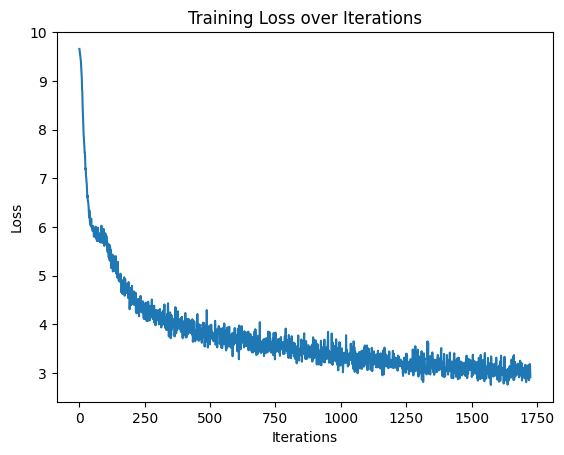

In [80]:
# Plot the training loss
plt.plot(all_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.show()

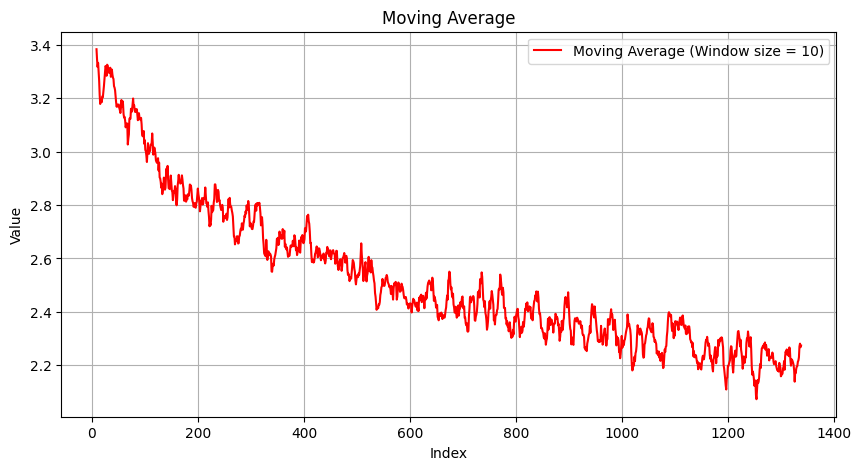

In [79]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    """Compute the moving average."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Sample data: list of floats
data = all_losses[50:]#[2.0, 2.5, 3.5, 4.0, 5.5, 6.0, 6.8, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]

# Set window size for moving average
window_size = 10

# Calculate moving average
avg_data = moving_average(data, window_size)

# Plot original data and moving average
plt.figure(figsize=(10,5))
#plt.plot(data, 'o-', label="Original Data")
plt.plot(range(window_size-1, len(data)), avg_data, 'r', label=f"Moving Average (Window size = {window_size})")
plt.legend()
plt.grid(True)
plt.title("Moving Average")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()


In [ ]:
import tiktoken
base_enc = tiktoken.get_encoding("gpt2")

In [ ]:
base_enc.decode([37189])

In [ ]:
for _ in range(10):
    token_id = base_enc.decode("")
    print(token_id)